# Random Forest Analysis

Random forest predicts a given boolean Y variable based on different combinations of X variables. In this script, we're predicting PD status using covariables (sex, etc) and/or metagenomic features (taxonomy, pathways). While we often build models that incorporate these comparisons using linear regression, linear regression isn't good at looking at the combined predictive power of multiple variables for a number of reasons. Here are some major ones:
1. It's extremely prone to overfitting and so can only handle a few input variables
2. There is no optimization (everything is always combined in the same way), so you're likely getting a good but not optimal solution
3. It expects that the variables are normal and that the relationships are linear

Random forest is a type of machine learning algorithm that tells you how well a group of variables describes/predicts another variable. It uses decision trees to categorize each sample. The variables for each model are randomly selected, and a portion of your data (the training subset) is used to determine whether the decision tree is able to accurately predict the sample category. It does this over and over with new decision trees - i.e. it is randomly selecting from a forest of trees. Eventually the best tree is presented as the final random forest model. The algorithm can also determine which variables are the most predictive based on how many times the variable appears in the most successful trees. The model is then tested on a test dataset. Ideally the training and test datasets show similarly high predictive power. It's not very good at describing the exact contributions of each variable individually.

In general, AUC values can be roughly interpreted as follows:

* Above 0.9: concerningly good, basically a direct relationship between the X and Y variables. Double check your code
*  0.8-0.9: excellent, exciting!
*  0.7-0.8: room for improvement, but moderately successful
*  0.6-0.7: nothing to write home about
*  0.4-0.6: definitely no predictive power observed
*  Less than 0.4: something may have gone horribly wrong. You have negative predictive power

# Set Up

In [1]:
# Load Python libraries
# Instead of loading whole pacakges, we often import specific functions only to save memory.
# We'll import certain key packages in their entirety, and usually assign them a short form to make coding easier (ex. pandas -> pd).
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from bootstrapped.bootstrap import bootstrap
import bootstrapped.stats_functions as bs_stats
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Font size for all plots
plt.rcParams.update({'font.size': 22})

# In Python, periods are somewhat similar to $ or @ in R, where a.b means that we're accessing b characteristic of a.
# For example, np.count means that we're accessing the count function from the np (numpy) package.

In [6]:
# ROC stands for Receiver Operating Characteristic, which is a type of curve that describes the quality of the model (the area-under-curve plots).
# There are multiple ways that the quality can be assessed. Here we're telling it that we want to use the area under curve (AUC) value as the metric, where bigger values are better.
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

# This function loads a dataset of interest, where the dataset must have the name "FOR RF - Status - (name specified in function)".
def format_fun(name):
    load = "MS_dataforRF_{name}.csv".format(name=name) # Change filepath as needed
    fdata = pd.read_csv(load)
    fdata = fdata.drop('Sample',axis=1) # fdata.drop applies the drop command to the fdata object (drops the given column (axis=1) or row (axis=2))

    # In random forest, the variables assessed should be numerical or binary (ie low, med, high doesn't work).
    # LabelEncoder changes characters and factors to 0s and 1s - ensure that there are only two values for each column beforehand.
    le = LabelEncoder()
    fdata['smoke'] = le.fit_transform(fdata['smoke'])
    fdata['disease'] = le.fit_transform(fdata['disease'])
    
    # Make three different datasets: fdata_var (covariables only), fdata_bac (no covariables), or the default fdata (everything combined).
    fdata_var = fdata[['age','smoke','disease']] # Covariables only
    fdata_bac = fdata.drop('age',axis=1) # Bacteria
    fdata_bac = fdata_bac.drop('smoke',axis=1)


    # Square brackets are equivalent to list() in R.
    # Make an empty list, then add the three datasets.
    ffiles = []
    ffiles.append(fdata_var)
    ffiles.append(fdata_bac)
    ffiles.append(fdata)

    # Record the order of the above three datasets in ffilenames.
    ffilenames = ["Covar",name,"{name} & Covar".format(name=name)]

    # We return a list of lists:
    results = [ffiles,ffilenames]
    return results

In [31]:
# Load Datasets
bac = format_fun('oldcombined')
all = format_fun('everything')
young = format_fun('youngcombinednewest')

# Random Forest Functions

In [35]:
# Plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# This function is embedded in the main random forest function below.
# We take all the random forest results as input in order to make a labelled ROC curve.
def plot_output (all_true_labels_val, all_predicted_probabilities_val,all_true_labels_train, all_predicted_probabilities_train, ci_lower_train, ci_upper_train, ci_lower_val,ci_upper_val,dataset_name):
    # Calculate ROC curve
    fpr_val, tpr_val, _ = roc_curve(all_true_labels_val, all_predicted_probabilities_val) # _val is the test dataset (what we're really interested in)
    fpr_train, tpr_train, _ = roc_curve(all_true_labels_train, all_predicted_probabilities_train) # This is the training dataset - should perform best since it was used to make the model
    # Calculate AUC using the curves we made above
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_auc_train = auc(fpr_train, tpr_train)
    # Plot ROC curve ~~~~~~~~~~~~~~
    plt.figure() # Initializes a new figure - must be eventually followed by plt.close()
    # for whatever reason, %0.2f can be used as a placeholder for variable text, similar to the .format command used previously. Placeholders are replaced in the order the variables are listed.
    plt.plot(fpr_train, tpr_train, color='black', linestyle='dotted', lw=2, label='Train: %0.2f (%0.2f-%0.2f)' % (roc_auc_train, ci_lower_train,ci_upper_train))
    plt.plot(fpr_val, tpr_val, color='black', lw=2, label='Test: %0.2f (%0.2f-%0.2f)' % (roc_auc_val, ci_lower_val,ci_upper_val))
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') # Middle line (basically random chance)
    # X and Y limits of the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    # Labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name}')
    plt.legend(loc='lower right')
   
    # Saving figure - change the file path as needed
    savename = "../MICB475RF/ROC Curve - Status - {df}.png".format(df=dataset_name)
    
    plt.savefig(savename, format="png", bbox_inches="tight")

    plt.show() # Print it below
    plt.close() # Stop writing to the plot file


# Run Random Forest Analysis - the main function!

def run_rf(data,data_name):
    
        # Separate features (X) and target variable (y)
        X = data.drop('disease', axis=1) # Everything but status
        y = data['disease'] # Status only

        # K fold cross validation: ensures that the random forest results aren't due to a lucky/unlucky test dataset.
        # Divides the dataset into n_splits groups. Entire RF procedure is run n_splits times, where each group takes a turn being the test dataset. 
        # Results are then averaged later on.
        skf = StratifiedKFold(n_splits=10) # When we call skf later on, it'll break the data into 10 groups

        # Define lists to store AUC scores
        train_auc_scores = []
        test_auc_scores = []

        # Define lists to store model data. Val = test
        all_true_labels_val = []
        all_predicted_probabilities_val = []
        all_true_labels_train = []
        all_predicted_probabilities_train = []
        feature_importance_values = [] # How much each variable contributes overall

        # Perform k-fold cross-validation
        # X and y are defined above. Each are split into 10 groups using skf.
        for train_index, test_index in skf.split(X, y): # Test the model on each permutation of the 10 groups
                X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[test_index] # Train and test X values
                y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index] # Train and test Y values

                # Train random forest model

                # model_hyper will run RF using these default settings. 
                model_hyper = RandomForestClassifier(class_weight='balanced_subsample',random_state=42)

                # Hyperparameter tuning using Grid Search - CRITICAL!
                # RF has lots of parameters - certain values are better in certain datasets. If you use default settings, you will probably get poor results.
                # We therefore run random forest multiple times using every combination of the parameters shown below.
                # Usually you adjust the values so that they're roughly appropriate for your dataset individually, and then provide a few values within that range for the hyperparameter tuning step. (From what I've seen, anyway!)
                # Fine line between optimization and bias - try to be as objective as possible.
                # FYI: there are a few other ways this tuning can be done as well.
                param_grid = {
                        'n_estimators': [150,250], # total number of trees assessed
                        'max_depth': [5,10], # number of decisions (features) per tree. Higher = more overfitting, lower = not enough info
                        'min_samples_leaf': [15,18,30], # See top answer here: https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre
                        'min_samples_split': [10,20,30], # Same as above
                        'bootstrap': [True]
                }
                # Using the param_grid and generic RF command defined above, define grid_search as: run RF on each combo of variables. Repeat 5x to ensure accuracy. Use AUC to quantify model performance (roc_scorer defined above).
                grid_search = GridSearchCV(
                        model_hyper, param_grid, cv=5, scoring=roc_scorer, n_jobs=-1
                )
                # Run the grid search algorithm on the training data
                grid_search.fit(X_train_fold, y_train_fold)

                # Finally define a RF algorithm that uses the optimized parameters
                model=RandomForestClassifier(class_weight='balanced_subsample',random_state=42, **grid_search.best_params_)

                # Finally: run the optimized RF algorithm on the training dataset!! Similar to above, but only uses the best combo of parameters from grid_search.
                model.fit(X_train_fold, y_train_fold)

                # Statistics ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                # Calculate AUC on training set
                train_pred_proba = model.predict_proba(X_train_fold)[:, 1]
                train_auc = roc_auc_score(y_train_fold, train_pred_proba)
                train_auc_scores.append(train_auc)

                # Calculate AUC on validation set (test set)
                test_pred_proba = model.predict_proba(X_val_fold)[:, 1]
                test_auc = roc_auc_score(y_val_fold, test_pred_proba)
                test_auc_scores.append(test_auc)

                # Append true labels and predicted probabilities to lists
                all_true_labels_val.extend(y_val_fold)
                all_predicted_probabilities_val.extend(test_pred_proba)
                all_true_labels_train.extend(y_train_fold)
                all_predicted_probabilities_train.extend(train_pred_proba)

                # Append feature importance values from this tree to the list
                feature_importance_values.append(model.feature_importances_)

        # Now we have the model stats for each k-fold individually - we need to combine them.

        # Bootstrap for uncertainty estimation
        # Honestly I'm not 100% sure how this works, but it's how we calculate the mean AUC as well as its range based on the k-folds
        bootstrapped_auc_val = bootstrap(np.array(test_auc_scores), stat_func=bs_stats.mean, num_iterations=1000)
        bootstrapped_auc_train = bootstrap(np.array(train_auc_scores), stat_func=bs_stats.mean, num_iterations=1000)

        # Extract bootstrapped statistic values
        bootstrapped_value_val = bootstrapped_auc_val.value
        ci_lower_val = bootstrapped_auc_val.lower_bound
        ci_upper_val = bootstrapped_auc_val.upper_bound

        bootstrapped_value_train = bootstrapped_auc_train.value
        ci_lower_train = bootstrapped_auc_train.lower_bound
        ci_upper_train = bootstrapped_auc_train.upper_bound

        # Feature Importance (contribution of individual variables to the model)
        mean_feature_importance = np.mean(feature_importance_values, axis=0) # Literally just the average importance value for each feature (variable)       
        importance_df = pd.DataFrame({ # Turn it into a nice dataframe, biggest to smallest importance
        'Feature': X.columns,
        'Importance': mean_feature_importance
        })
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Create AUC plot using function defined above 
        plot_output(all_true_labels_val, all_predicted_probabilities_val,all_true_labels_train, all_predicted_probabilities_train, ci_lower_train, ci_upper_train, ci_lower_val,ci_upper_val,data_name)

        # Save Statistics
        temp = pd.DataFrame({
        'Dataset': [data_name],
        'Analysis': ['disease'],
        'Training AUC': [round(bootstrapped_value_train,2)],
        'Training AUC CI': ["{low}-{high}".format(low=round(ci_lower_train,2),high=round(ci_upper_train,2))],
        'Testing AUC': [round(bootstrapped_value_val,2)],
        'Testing AUC CI': ["{low}-{high}".format(low=round(ci_lower_val,2),high=round(ci_upper_val,2))]
        },index=[0])

        results = [temp,importance_df]
        return results

# Run RF On Datasets

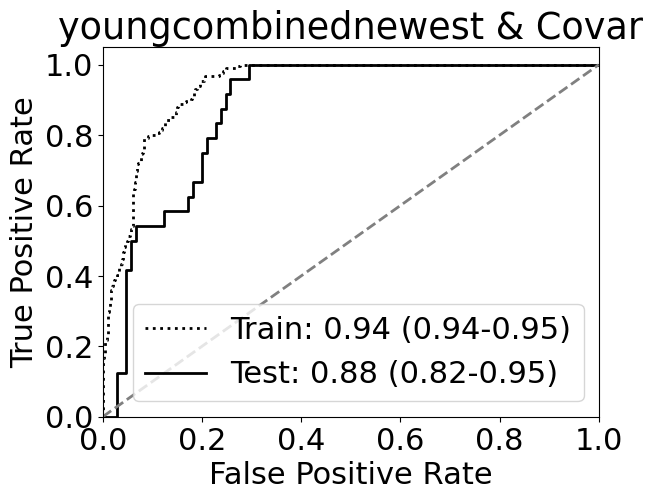

In [36]:
# Remember that for each dataset (bac, meta), we loaded a list of lists where the first sublist contains the three subdatasets
# (covars, metagenomics, everything) and the second sublist contains the corresponding names for each subdataset.
# In Python, indices start at 0 instead of 1 like in R.

# Covars (using bac arbitrarily - should be identical covariables in bac and meta)
#data = bac[0][0]
#name = bac[1][0]
#covars = run_rf(data=data,data_name=name)

# Taxonomy
#data = bac[0][1]
#name = bac[1][1]
#taxonomy = run_rf(data=data,data_name=name)

# Taxonomy & Covars
#data = bac[0][2]
#name = bac[1][2]
#tax_cov = run_rf(data=data,data_name=name)

# Taxonomy & Covars
data = young[0][2]
name = young[1][2]
tax_cov = run_rf(data=data,data_name=name)

# Taxonomy
#data = all[0][1]
#name = all[1][1]
#axonomy = run_rf(data=data,data_name=name)

# Taxonomy & Covars
#data = all[0][2]
#name = all[1][2]
#tax_cov = run_rf(data=data,data_name=name)



# Save Importance Values and Stats

In [38]:
# Save importance values - change the file path as needed
name = "../MICB475RF/RF_Importance_Values_ms.xlsx"
writer=pd.ExcelWriter(name)

taxonomy[1].to_excel(writer,sheet_name="Taxonomy")
tax_cov[1].to_excel(writer,sheet_name="Taxonomy & Covars")

writer.close()


# Save statistics
temp = [taxonomy[0],tax_cov[0]]
comb_temp = pd.concat(temp,axis=0)
comb_temp.reset_index(drop=True, inplace=True)

name = "../MICB475RF/RF_Statistics_ms.xlsx"
writer=pd.ExcelWriter(name)
comb_temp.to_excel(writer,sheet_name="RF AUC Values")
writer.close()